<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=300 height=300 align=left class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<div dir=ltr align=center>

<font color=3C99D size=5>
    Practical Assignment 5 - Reinforcement Learning <br>
<font color=696880 size=4>
    Kiarash Joolaei


# Personal Data

In [2]:
student_number = '400100616'
name = 'Setayesh Esteki'

**Note :** This notebook is optional.

Although in many cases classic RL algorithms such as  QLearning perform pretty well, there are also cases where they can fall short. In this notebook we will explore these shortcomings while also introducing more effective variants for such algorithms.

# Q-Learning vs. Deep Q-Learning

### Q-Learning

**Q-Learning** is a model-free reinforcement learning algorithm used to learn the optimal action-value function $ Q(s, a) $ for a given environment. It operates by iteratively updating $ Q $-values using the Bellman equation, based on the rewards received and the agent's estimate of future rewards. Q-learning is effective in small, discrete state-action spaces where a table can be used to store $ Q $-values. However, as the size or complexity of the environment grows, maintaining and updating a table for all state-action pairs becomes computationally infeasible, and the algorithm struggles to generalize across states.

### Deep Q-Learning

**Deep Q-Learning (DQN)** addresses these limitations by approximating the $ Q $-value function using a deep neural network. Instead of storing $ Q(s, a) $ values in a table, the neural network takes a state $ s $ as input and outputs $ Q $-values for all possible actions. This allows DQN to handle environments with large or continuous state spaces, such as video games or robotics tasks. Deep Q-learning also introduces techniques like experience replay and target networks to stabilize training. DQN is particularly needed in scenarios where the state space is high-dimensional, such as pixel-based input (e.g., images from a game), where tabular methods are impractical, and learning representations through a neural network is necessary for effective decision-making.


Here we will implement both Q-Learning and Deep Q-Learning on the environment `LunarLander-v2`. This environment consists of a Discrete action space with four possible actions:

0: do nothing

1: fire left orientation engine

2: fire main engine

3: fire right orientation engine

The state space however consists of 8-dimensional continuous states: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not. The continuity of the state space lets us use a neural network to estimate $Q$-values as a function with state as input and $Q$-values for all actions.

# Libraries

In [5]:
!sudo apt-get update --quiet
!pip install imageio --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip install swig --quiet
!pip install gymnasium[box2d] --quiet
from IPython.display import clear_output
clear_output()

Import the neccesary libraries here.

In [3]:
import gymnasium as gym
import random
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple, deque

import base64
import json
import imageio
import IPython

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import random
import time
from IPython.display import clear_output, HTML
from base64 import b64encode
from moviepy.editor import ImageSequenceClip
from typing import Tuple


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

ModuleNotFoundError: No module named 'moviepy'

These are some helper functions that can visualize the outcome of a sampled trajectory. They will be useful later.

In [38]:
import logging
logging.getLogger().setLevel(logging.ERROR)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards, show_result=False):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, agent, filename, num_episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(device)
                action = agent.act(state, greedy=True)
                state, reward, terminated, truncated, info = env.step(action.item())
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)



def save_progress(sum_of_rewards, PATH):
    # Convert the list to a JSON string
    json_data = json.dumps(sum_of_rewards)
    # Write the JSON data to a file
    with open(PATH + str('.json'), "w") as file:
        file.write(json_data)


def load_progress(PATH):
    with open(PATH + str('.json'), "r") as file:
        json_data = file.read()
    # Load the JSON data back into a Python list
    return json.loads(json_data)

# Q-Learning

Here you should implement the `QLearningAgent` class. Note that since the state space is continuous, you will need to discretize states as some state bins in order to use the classic Q-Learning algorithm (number of bins is optional).

In [16]:
class QLearningAgent(object):
    def __init__(self, env, learning_rate, discount_factor, epsilon, epsilon_decay, epsilon_min, state_bins):
        ####TODO####

    def discretize_state(self, state):
        ####TODO####
        pass

    def act(self, state, greedy=True):
        #Random or epsilon-greedy-policy
        ####TODO####
        pass

    def update_q_value(self, state, action, reward, next_state, done):
        #Update Qtable based on the update rule
        ####TODO####


    def decay_epsilon(self):
        ####TODO####
    def train(self, num_episodes):
        ####TODO####


# Deep Q-Network

In this part, you need to implement a deep q-network (DQN). When implementing DQN it's common to use a replay buffer. A replay buffer in deep reinforcement learning stores past experiences so the agent can sample them randomly during training. This helps break correlations in sequential data, improves sample efficiency by reusing experiences, stabilizes training by providing a consistent data distribution, and reduces the variance in gradient updates. The class `ReplayBuffer` code is given to you. Push the trajectory to the buffer while training the network and sample from it when updating the network.


<p align="center">
  <img src="https://www.researchgate.net/publication/346346921/figure/fig5/AS:962138164178960@1606403022784/llustration-of-the-replay-buffer-in-the-RL.ppm" alt="Replay Buffer Illustration" width="600">
</p>


In [28]:
class ReplayBuffer(object):

    def __init__(self, capacity, batch_size):
        self.memory = deque([], maxlen=capacity)
        self.batch_size = batch_size
        transition_tuple = ('state', 'action', 'reward', 'next_state', 'done')
        self.experience = namedtuple('Experience', transition_tuple)

    def push(self, state, action, reward, next_state, done):

        new_experience = self.experience(state=state, action=action, reward=reward, next_state=next_state, done=done)
        self.memory.append(new_experience)

    def sample(self):

        size = min(self.batch_size, len(self.memory))
        sample = random.sample(self.memory, size)

        states = torch.cat([exp.state for exp in sample])
        actions = torch.cat([exp.action for exp in sample])
        rewards = torch.cat([exp.reward for exp in sample])
        next_states = torch.cat([exp.next_state for exp in sample])
        dones = torch.cat([exp.done for exp in sample])

        # Return the concatenated values
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

In this part we must design our Agent class which is the must important part of the notebook. First let's take a look at its methods:


*   `__init__` : initializes the agent, by receiving it the q_network, replay memory, optimize, criterion, and a dictionary of paramters which hold the hyperparameters of the agent.
*   `step` : allows the agent to store an experience in its memory and if necessary, it initiates the learning process.
*   `act` : by receiving a state and boolean value for choosing a greedy action, if the boolean value is false, it selects an $\varepsilon$-greedy action by passing the state to the policy network of the agent, and select the action with the highest state-action value. The $\varepsilon$ value is calculated using the following formula: $$\varepsilon = \varepsilon_{end} + \left(\varepsilon_{start} - \varepsilon_{end}\right)\exp\left(-\frac{\text{steps done}}{\text{decay rate}}\right)$$
*   `learn` : first computes the predicted Q-values for the observed states and actions using the policy network. Then, it computes the expected Q-values for the next states by evaluating the target network, incorporating rewards and discount factors. After computing the loss between predicted and expected Q-values, the function optimizes the model parameters using gradient descent. Additionally, it calls the soft update function to gradually update the target network's parameters towards the policy network's parameters.
*   `soft_update` : The target network is updated at every step with a soft update controlled by the hyperparameter $\tau$, which was previously defined. The target is updated according to: $$\theta' \leftarrow \tau \theta + (1 - \tau) \theta'$$ where $\theta'$ are the parameters of the target network and $\theta$ are the parameters of the policy network.
*   `save` and `load` : are used for saving and loading the policy and target networks of the agent.

In [29]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(QNetwork, self).__init__()
        ####TODO####

    def forward(self, x):
        ####TODO####
        pass

In [30]:
class DQLearningAgent(object):

    def __init__(self, q_network, memory, optimizer, criterion, params, env):
        # TODO: Create policy and target nets based on the q-net

        # TODO: Setup the agent's memory

        # criterion, optimizer and params
        self.criterion = criterion
        self.optimizer = optimizer(self.policy_net.parameters(), lr=params['LR'], amsgrad=True)
        self.tau = params['TAU']
        self.gamma = params['GAMMA']
        self.update_rate = params['UPDATE_RATE']
        self.eps = {'START': params['EPS_START'], 'END': params['EPS_END'], 'DECAY': params['EPS_DECAY']}
        # Set steps counter to zero
        self.steps_done = 0

    def step(self, state, action, reward, next_state, done):
        # TODO: Save the experience in the memory of the agent
        self.memory.push(state, action, reward, next_state, done)

        # TODO: Increment the steps counter
        self.steps_done += 1

        if self.steps_done % self.update_rate == 0 and len(self.memory) > self.memory.batch_size:
            # TODO: Sample a batch from memory and learn from it


    def act(self, state, greedy=False):
        eps_threshold = self.eps['END'] + (self.eps['START'] - self.eps['END']) * np.exp(- self.steps_done / self.eps['DECAY'])
        self.policy_net.eval()
        if greedy or random.random() > eps_threshold:
              # TODO: Select greedy action

        else: # TODO: Select random action

    def learn(self, states, actions, rewards, next_states, dones):
        # TODO: Compute the predicted Q-values using the policy network

        # TODO: Compute expected Q-values using the target network (don't forget to use no_grad)

        # TODO: Compute the loss

        # TODO: Optimize the model

        # TODO: Run soft update


    def soft_update(self):
        # TODO: Soft update of all weights in the target network

    def train(self):
          num_episodes = self.num_episodes
          env = self.env

          for i_episode in range(1, num_episodes + 1):
              # TODO: Initialize the environment and get its state

              while not done:
                  # TODO: Take an Ɛ-greedy action

                  # TODO: Take a step in the environment

                  # TODO: Update done status

                  # TODO: Update sum of rewards for current episode

                  # TODO: Convert action to tensor

                  # TODO: Convert reward to tensor

                  # TODO: Convert the next state into tensor

                  # TODO: Store the termination status into a tensor

                  # TODO: Store the experience in memory

                  # TODO: Move to the next state

              # TODO: Update and plot rewards

              # Save model every 100 episodes (change the rate if needed)
              if i_episode % 100 == 0:
                  path = 'DQN_' + str(len(sum_of_rewards)).zfill(4)
                  agent.save(path)
                  save_progress(sum_of_rewards, path)

          return sum_of_rewards


    def save(self, PATH):
        torch.save(self.policy_net, PATH + '_policy.pt')
        torch.save(self.target_net, PATH + '_target.pt')

    def load(self, PATH):
        self.policy_net = torch.load(PATH + '_policy.pt')
        self.target_net = torch.load(PATH + '_target.pt')

# Training

Everything is now set to test on `LunarLander-v3`. Set the sutiable hyperparameters for both Q-Learning and DQN and plot the rewards for each as well.

In [31]:
env = gym.make("LunarLander-v3")
spec = gym.spec("LunarLander-v3")

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Threshold: {spec.reward_threshold}\n")


Action Space: Discrete(4)
Observation Space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Threshold: 200



In [6]:
state_bins = ...
learning_rate = ...
discount_factor = ...
epsilon = ...
epsilon_decay = ...
epsilon_min = ...
batch_size = ...
memory_capacity = ...
target_update_frequency = ...
hidden_dim = ...
num_episodes = ...

Episode 100/1000, Total Reward: -113.804690420994, Epsilon: 0.606
Episode 200/1000, Total Reward: -231.66291349919848, Epsilon: 0.367
Episode 300/1000, Total Reward: -91.7823646916465, Epsilon: 0.222
Episode 400/1000, Total Reward: -168.38307565971223, Epsilon: 0.135
Episode 500/1000, Total Reward: -139.4564330874521, Epsilon: 0.082
Episode 600/1000, Total Reward: -341.51637614257345, Epsilon: 0.049
Episode 700/1000, Total Reward: -28.038232533622747, Epsilon: 0.030
Episode 800/1000, Total Reward: -118.41193665175277, Epsilon: 0.018
Episode 900/1000, Total Reward: -158.5009828253803, Epsilon: 0.011
Episode 1000/1000, Total Reward: -85.6700250185713, Epsilon: 0.010


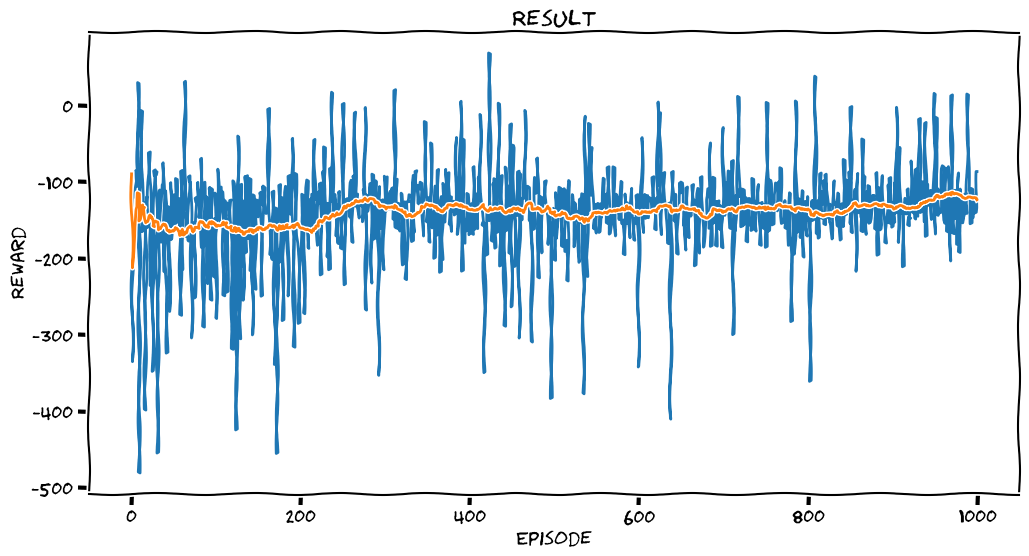

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [8]:
# Q-Learning
q_agent = QLearningAgent(
    env=env,
    state_bins=state_bins,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
)
rewards = q_agent.train(num_episodes=num_episodes)
plot_rewards(rewards, show_result=True)
plt.ioff()
plt.show()


In [32]:
params = {
    'UPDATE_RATE': ...,      # how often to update the network
    'BUFFER_SIZE': ...,     # size of the replay buffer
    'BATCH_SIZE': ...,       # number of experiences sampled from memory
    'GAMMA': ...,           # discount factor
    'EPS_START': ...,         # starting value of epsilon
    'EPS_END': ...,         # final value of epsilon
    'EPS_DECAY': ...,        # rate of exponential decay of epsilon
    'TAU': ...,             # update rate of the target network
    'LR': ...,              # learning rate of the optimizer
    'HIDDEN_DIMS': ...,  # hidden dimensions of the neural network
    'EPISODE_NUM': ...,     # number of training episodes
}

env = gym.make("LunarLander-v3")
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

sum_of_rewards = list()

# TODO: Choose optimizer and loss function
optimizer = ...
criterion = ...

# TODO: Get an instance of the agent class
memory = ReplayBuffer(params['BUFFER_SIZE'], params['BATCH_SIZE'])
agent = ...

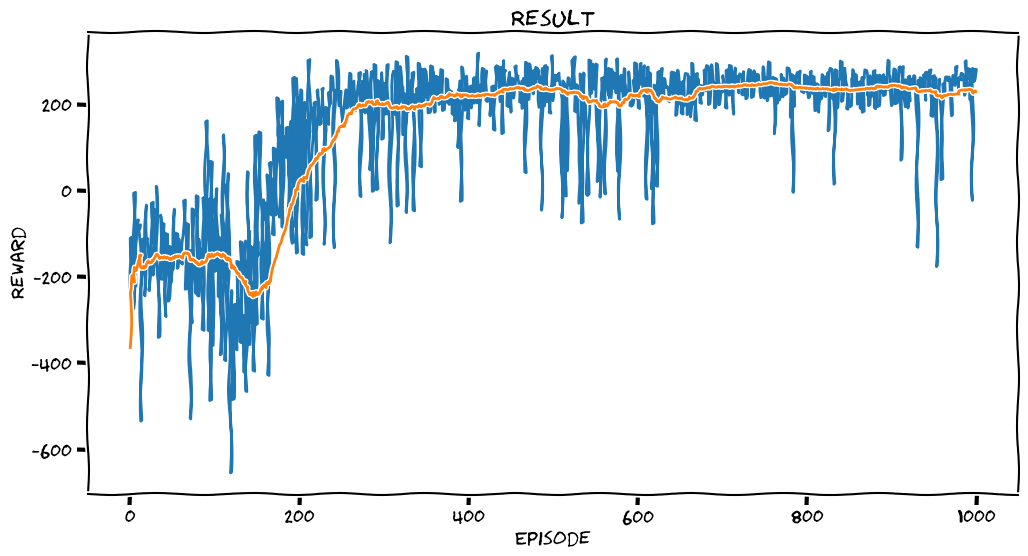

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [33]:
sum_of_rewards = agent.train()
plot_rewards(sum_of_rewards, show_result=True)
plt.ioff()
plt.show()

# Evaluation

In order to evaluate the model, we use the following function to measure the average reward and it's standard deviation.

In [34]:
def evaluate_policy(env, agent, num_episodes=10):
    # TODO: Initialize sum of rewards

    for episode in range(num_episodes):
        # TODO: Initialize environment
        # TODO: Run policy
        while not done:
            # TODO: Update sum of rewards for current episode

            # TODO: Break if terminated or truncated

    # TODO: Return mean and std of rewards


The code below will be used for simple Q-Learning evaluation.

In [ ]:
def evaluate_policy_q(env, agent, num_episodes=10):
    total_rewards = []
    for _ in range(num_episodes):
        state = agent.discretize_state(env.reset()[0])
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state, greedy=True)
            next_state_raw, reward, done, _, _ = env.step(action)
            state = agent.discretize_state(next_state_raw)
            total_reward += reward
        total_rewards.append(total_reward)

    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    return mean_reward, std_reward


In [35]:
#Q-Learning reward
mean_reward, std_reward = evaluate_policy_q(env, q_agent)
print(f"mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

mean_reward = -137.89 +/- 38.3316


In [36]:
#DQN reward
mean_reward, std_reward = evaluate_policy(env, agent)
print(f"mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

mean_reward = 235.45 +/- 72.1544


In [39]:
#DQN result
env = gym.make("LunarLander-v3", render_mode='rgb_array')
create_policy_eval_video(env, agent, 'greedy_policy', 3)

**Question :** Which of these algorithms have better results? What causes the gap in these results?

**Answer :**